In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

In [3]:
# Read Sim data
data_sim = pd.read_csv('data.txt',index_col=0)
pd.set_option('display.max_columns', 12)

# Adding Noise
np.random.seed(1)
for col in data_sim:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data_sim[col]))
        data_sim[col] = data_sim[col] - noise

# Remove Sim targets
data_sim.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1_sim = data_sim.Contains_Crack
y2_sim = data_sim.Position_of_Crack
data_sim.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)

# Encoding targets
for idx in range(len(y1_sim)):
    if y1_sim[idx] == 'Yes':
        y1_sim[idx] = int(1)
    elif y1_sim[idx] == 'No': 
        y1_sim[idx] = int(0)
    
    if y2_sim[idx] == 'No Crack':
        y2_sim[idx] = int(0)
    elif y2_sim[idx] == 'Top Right':
        y2_sim[idx] = int(1)
    elif y2_sim[idx] == 'Top Left':
        y2_sim[idx] = int(2)
    elif y2_sim[idx] == 'Bottom Left':
        y2_sim[idx] = int(3)
    elif y2_sim[idx] == 'Bottom Right':
        y2_sim[idx] = int(4)
        
y1_sim = y1_sim.to_numpy(dtype=int)
y2_sim = y2_sim.to_numpy(dtype=int)

# Split the sim data into feature sets
X1_sim = data_sim
X2_sim = data_sim[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data_sim[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data_sim[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data_sim[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data_sim[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data_sim[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3_sim = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

data_sim

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,162.869542,1.046061,1.004936,-0.021230,1.011708,1.240270,...,830.566215,-0.035678,0.009109,-0.036366,-0.021224,0.077989
1,160.494390,1.042447,1.034867,0.068796,1.019208,1.233117,...,822.431163,0.819406,0.003656,0.044100,0.460452,0.220691
2,165.649327,1.134330,1.002824,0.042878,1.032506,1.126788,...,832.976194,0.246206,0.508042,-0.035659,0.185458,0.213428
3,162.649339,1.046939,1.037994,0.039930,1.047922,1.214029,...,842.489399,-0.002791,-0.065931,0.068475,0.024622,0.071422
4,164.121992,1.027504,1.036951,0.038677,1.044667,1.009505,...,837.295157,0.063517,0.155301,-0.035993,0.083589,0.099727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,163.642028,1.016874,1.078402,-0.023407,1.022212,1.192270,...,833.237794,0.113037,0.158271,-0.051252,0.043492,0.128825
96,158.412726,1.052195,1.133167,0.098517,1.021752,1.201091,...,831.027714,0.117744,0.225690,0.190588,0.214928,0.039753
97,161.989736,1.044556,1.058207,-0.014622,1.027143,1.104218,...,831.365719,0.093679,0.369428,0.108671,0.148099,0.138575
98,166.217901,1.011329,1.004270,0.049064,1.123570,1.282767,...,826.276980,0.233161,0.532417,0.158622,0.179063,0.065291


In [7]:
# Read Exp data
pd.set_option('display.max_columns', 12)
data_exp = pd.read_csv('experiment_data.txt',index_col=0)

# Remove Exp targets
data_exp.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1_exp = data_exp.Contains_Crack
y2_exp = data_exp.Position_of_Crack
data_exp.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
    
# Split the Exp data into feature sets
X1_exp = data_exp
X2_exp = data_exp[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data_exp[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data_exp[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data_exp[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data_exp[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data_exp[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3_exp = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

# Encoding targets
for idx in range(len(y1_exp)):
    if y1_exp[idx] == 'Yes':
        y1_exp[idx] = int(1)
    elif y1_exp[idx] == 'No': 
        y1_exp[idx] = int(0)
    
    if y2_exp[idx] == 'No Crack':
        y2_exp[idx] = int(0)
    elif y2_exp[idx] == 'Top Right':
        y2_exp[idx] = int(1)
    elif y2_exp[idx] == 'Top Left':
        y2_exp[idx] = int(2)
    elif y2_exp[idx] == 'Bottom Left':
        y2_exp[idx] = int(3)
    elif y2_exp[idx] == 'Bottom Right':
        y2_exp[idx] = int(4)
        
y1_exp = y1_exp.to_numpy(dtype=int)
y2_exp = y2_exp.to_numpy(dtype=int)

C:\Users\James\AppData\Local\Temp/ipykernel_9980/1788654838.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1_exp[idx] = int(0)
C:\Users\James\AppData\Local\Temp/ipykernel_9980/1788654838.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y2_exp[idx] = int(0)
C:\Users\James\AppData\Local\Temp/ipykernel_9980/1788654838.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1_exp[idx] = int(1)
C:\Users\James\AppData\Local\Temp/ipy

In [ ]:
# Transforming units

In [12]:
# Mean Center the data
for col in X1_sim:
    X1_exp[col] = X1_exp[col]*((X1_sim[col].max())/(X1_exp[col].max())) - X1_sim[col].mean()
    X1_sim[col] = X1_sim[col] - X1_sim[col].mean()

for col in X2_sim:
    X2_exp[col] = X2_exp[col]*((X2_sim[col].max())/(X2_exp[col].max())) - X2_sim[col].mean()
    X2_sim[col] = X2_sim[col] - X2_sim[col].mean()
    
for col in X3_sim:
    X3_exp[col] = X3_exp[col]*((X3_sim[col].max())/(X3_exp[col].max())) - X3_sim[col].mean()
    X3_sim[col] = X3_sim[col] - X3_sim[col].mean()

C:\Users\James\AppData\Local\Temp/ipykernel_9980/4078101616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_exp[col] = X2_exp[col]*((X2_sim[col].max())/(X2_exp[col].max())) - X2_sim[col].mean()
C:\Users\James\AppData\Local\Temp/ipykernel_9980/4078101616.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_sim[col] = X2_sim[col] - X2_sim[col].mean()


# Comparison

In [13]:
print(X3_exp)

       amp1      amp2      amp3      amp4      amp5
0  0.457971 -0.397657  0.097304  0.342136  2.619646
1 -0.248909  0.566393  0.202447  0.224311  0.151519
2  0.015453 -0.343167 -0.400370  0.454839  0.267818
3  0.429236 -0.414423  0.055247  0.977369  0.565027
4 -0.610969  0.134666 -0.035876  0.864667  1.999383
5 -0.616716  1.350207  0.076276  0.362628  0.616715
6  1.233815 -0.691063 -0.337285 -0.159902  2.955621
7  0.883249 -0.812617 -0.267190 -0.882223  2.606724
8 -0.766138 -0.481487 -0.218123  1.223266  1.482498


In [14]:
print(X3_sim)

        amp1      amp2      amp3      amp4      amp5
0  -0.018311 -0.013952  0.020307 -0.135179 -0.198970
1  -0.100273 -0.238541 -0.089617 -0.057351  0.082868
2   0.685834 -0.047157 -0.074528  0.042888 -0.563159
3   0.008581 -0.101400  0.106646  0.275337  0.068219
4   0.476753 -0.102649  0.044500 -0.130495  0.078536
..       ...       ...       ...       ...       ...
95 -0.144426 -0.085947 -0.040457  0.019560 -0.695826
96  0.349585  0.885678 -0.040338 -0.259913  0.404822
97 -0.507189 -0.525177 -0.001301 -0.579787  0.006762
98 -0.255754 -0.428004 -0.051220  0.913144  0.102665
99 -0.428537 -0.313512  0.085078  0.556518 -0.381773

[100 rows x 5 columns]


# SVM

Predicted values using x1 and y1: [0 0 0 1 0 0 0 0 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.2222222222222222 and AUC score of 0.5625 



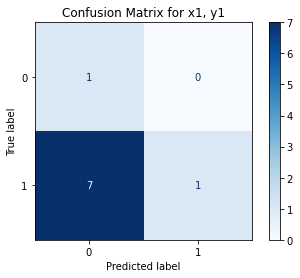

Predicted values using x2 and y1: [0 0 0 1 0 0 0 0 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.2222222222222222 and AUC score of 0.5625 



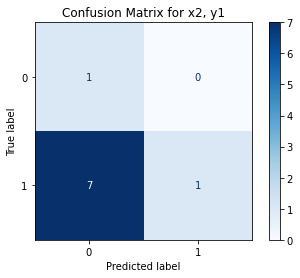

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



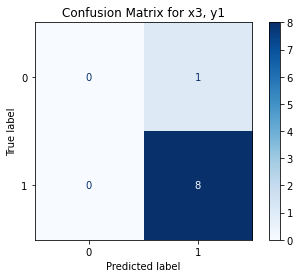

In [15]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y1
x1y1 = svm.SVC(cache_size=1000)
x1y1_svm = GridSearchCV(x1y1, param_grid)
x1y1_svm.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_svm.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_svm,X1_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1 = svm.SVC(cache_size=1000)
x2y1_svm = GridSearchCV(x2y1, param_grid)
x2y1_svm.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_svm.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_svm,X2_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1 = svm.SVC(cache_size=1000)
x3y1_svm = GridSearchCV(x3y1, param_grid)
x3y1_svm.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_svm.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_svm,X3_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [0 0 0 1 0 0 0 0 3]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.15 and AUC score of 0.6291666666666667 



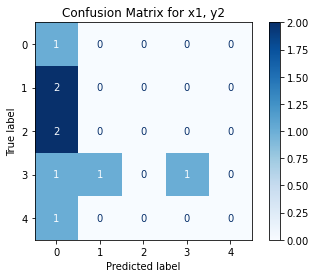

KeyboardInterrupt: 

In [16]:
# x1 y2
x1y2 = svm.SVC(cache_size=1000, probability=True)
x1y2_svm = GridSearchCV(x1y2, param_grid)
x1y2_svm.fit(X1_sim, y2_sim)

x1y2_predict = x1y2_svm.predict(X1_exp)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_svm.predict_proba(X1_exp)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_svm,X1_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2 = svm.SVC(cache_size=1000, probability=True)
x2y2_svm = GridSearchCV(x2y2, param_grid)
x2y2_svm.fit(X2_sim, y2_sim)

x2y2_predict = x2y2_svm.predict(X2_exp)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_svm.predict_proba(X2_exp)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_svm,X2_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_svm = svm.SVC(cache_size=1000, probability=True, C=100, gamma=0.06, kernel='rbf')
x3y2_svm.fit(X3_sim, y2_sim)

x3y2_predict = x3y2_svm.predict(X3_exp)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_svm.predict_proba(X3_exp)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_svm,X3_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

# Bayesian Network

Predicted values using x1 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



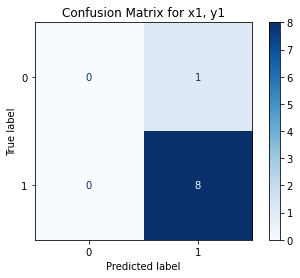

Predicted values using x2 and y1: [0 0 0 1 0 0 0 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.4 and AUC score of 0.625 



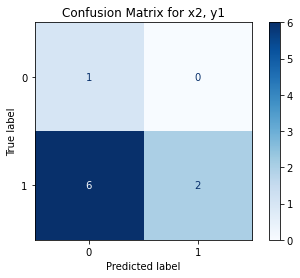

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



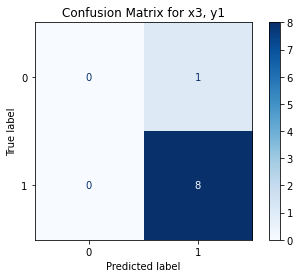

In [17]:
# x1 y1
x1y1_gnb = GaussianNB()
x1y1_gnb.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_gnb.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_gnb,X1_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_gnb = GaussianNB()
x2y1_gnb.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_gnb.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_gnb,X2_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_gnb = GaussianNB()
x3y1_gnb.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_gnb.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_gnb,X3_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 4 2 2 1 2 2 2 2]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.1 and AUC score of 0.5166666666666666 



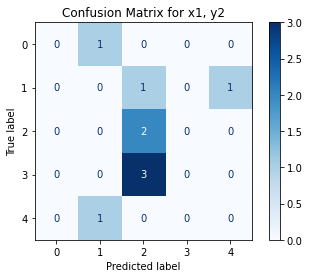

Predicted values using x2 and y2: [0 0 0 2 0 0 0 0 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.05 and AUC score of 0.6499999999999999 



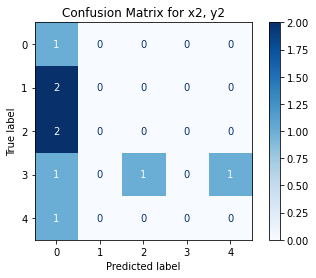

Predicted values using x3 and y2: [4 2 2 3 4 1 4 4 3]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.5555555555555556 and f1 score of: 0.47333333333333333 and AUC score of 0.6333333333333334 



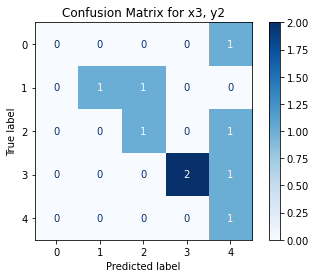

In [18]:
# x1 y2
x1y2_gnb = GaussianNB()
x1y2_gnb.fit(X1_sim, y2_sim)

x1y2_predict = x1y2_gnb.predict(X1_exp)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_gnb.predict_proba(X1_exp)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_gnb,X1_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_gnb = GaussianNB()
x2y2_gnb.fit(X2_sim, y2_sim)

x2y2_predict = x2y2_gnb.predict(X2_exp)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_gnb.predict_proba(X2_exp)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_gnb,X2_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_gnb = GaussianNB()
x3y2_gnb.fit(X3_sim, y2_sim)

x3y2_predict = x3y2_gnb.predict(X3_exp)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_gnb.predict_proba(X3_exp)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_gnb,X3_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

# KNN

Predicted values using x1 and y1: [0 1 0 1 0 0 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.5555555555555556 and f1 score of: 0.6666666666666666 and AUC score of 0.75 



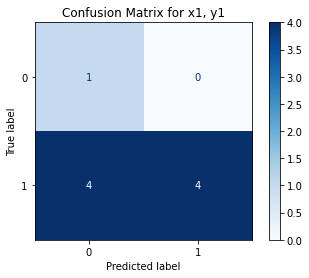

Predicted values using x2 and y1: [0 1 0 1 0 0 1 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.5555555555555556 and f1 score of: 0.6666666666666666 and AUC score of 0.75 



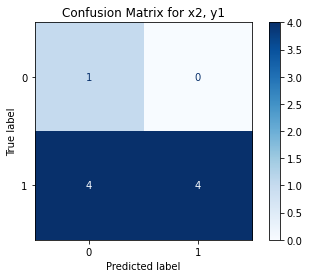

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



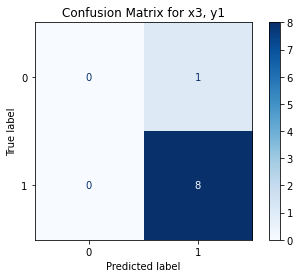

In [19]:
n_neighbors = 5
# x1 y1
x1y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y1_nn.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_nn.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_nn,X1_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y1_nn.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_nn.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_nn,X2_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y1_nn.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_nn.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_nn,X3_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [0 0 0 2 0 0 0 0 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.05 and AUC score of 0.7208333333333333 



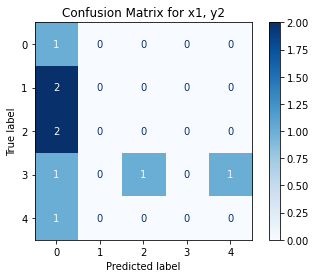

Predicted values using x2 and y2: [0 0 0 2 0 0 0 0 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.05 and AUC score of 0.7208333333333333 



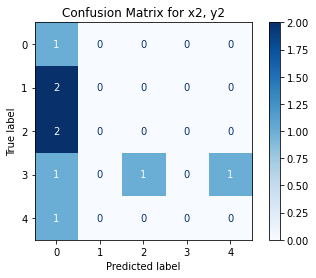

Predicted values using x3 and y2: [4 1 1 3 4 1 4 4 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.4444444444444444 and f1 score of: 0.32666666666666666 and AUC score of 0.6979166666666666 



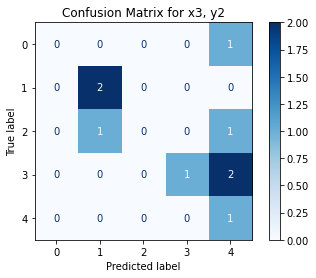

In [20]:
n_neighbors = 3
# x1 y2
x1y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y2_nn.fit(X1_sim, y2_sim)

x1y2_predict = x1y2_nn.predict(X1_exp)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_nn.predict_proba(X1_exp)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_nn,X1_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y2_nn.fit(X2_sim, y2_sim)

x2y2_predict = x2y2_nn.predict(X2_exp)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_nn.predict_proba(X2_exp)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_nn,X2_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y2_nn.fit(X3_sim, y2_sim)

x3y2_predict = x3y2_nn.predict(X3_exp)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_nn.predict_proba(X3_exp)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_nn,X3_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

# Decision Trees

Predicted values using x1 and y1: [0 1 1 1 1 1 1 1 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9333333333333333 and AUC score of 0.9375 



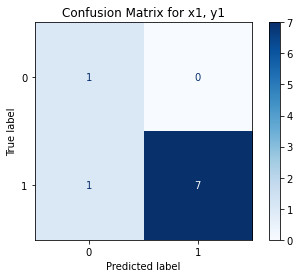

Predicted values using x2 and y1: [0 1 0 1 0 0 0 0 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.4 and AUC score of 0.625 



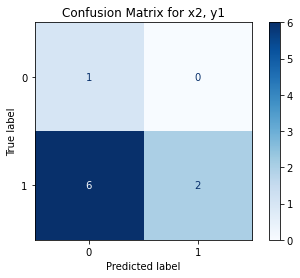

Predicted values using x3 and y1: [1 0 1 1 0 0 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.5555555555555556 and f1 score of: 0.7142857142857143 and AUC score of 0.3125 



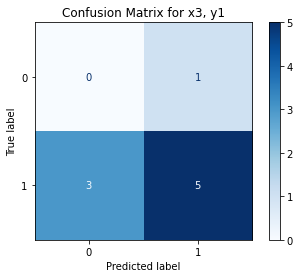

In [21]:
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_tree.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X1_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_tree.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X2_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_tree.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X3_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [0 0 1 1 1 2 1 1 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.13333333333333333 and AUC score of 0.5 



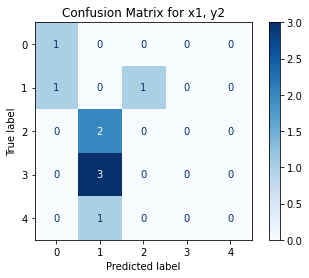

Predicted values using x2 and y2: [0 0 0 3 0 0 0 0 1]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.15 and AUC score of 0.5416666666666666 



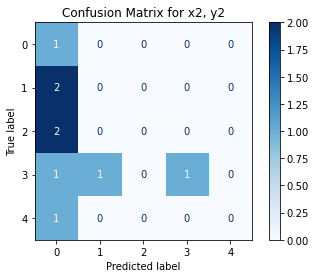

Predicted values using x3 and y2: [2 2 3 2 4 1 4 2 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.2222222222222222 and f1 score of: 0.2333333333333333 and AUC score of 0.5625 



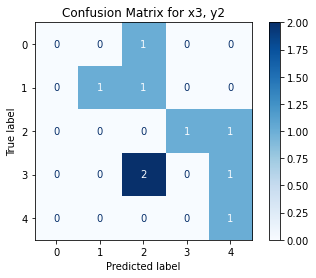

In [22]:
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X1_sim, y2_sim)

x1y2_predict = x1y2_tree.predict(X1_exp)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X1_exp)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X1_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X2_sim, y2_sim)

x2y2_predict = x2y2_tree.predict(X2_exp)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X2_exp)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X2_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X3_sim, y2_sim)

x3y2_predict = x3y2_tree.predict(X3_exp)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X3_exp)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X3_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

# Neural Networks

Predicted values using x1 and y1: [0 1 0 1 0 0 0 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.4444444444444444 and f1 score of: 0.5454545454545454 and AUC score of 0.6875 



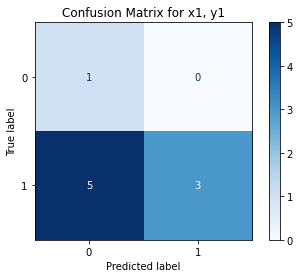

Predicted values using x2 and y1: [0 1 0 1 0 0 0 0 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.4444444444444444 and f1 score of: 0.5454545454545454 and AUC score of 0.6875 



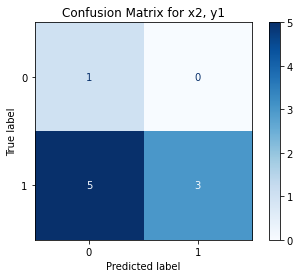

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.8888888888888888 and f1 score of: 0.9411764705882353 and AUC score of 0.5 



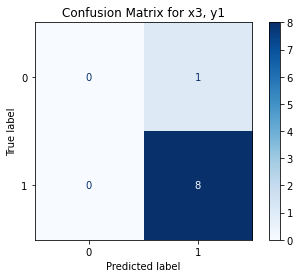

In [23]:
# x1 y1
x1y1_MLP = MLPClassifier(max_iter=2000,solver='lbfgs',early_stopping=True,learning_rate='adaptive',activation='tanh',hidden_layer_sizes=1500,alpha=0.09)
x1y1_MLP.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_MLP.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_MLP,X1_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_MLP = MLPClassifier(max_iter=2000,solver='lbfgs',early_stopping=True,learning_rate='adaptive',activation='tanh',hidden_layer_sizes=1500,alpha=0.09)
x2y1_MLP.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_MLP.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_MLP,X2_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_MLP = MLPClassifier(max_iter=2000,solver='lbfgs',early_stopping=True,learning_rate='adaptive',activation='tanh',hidden_layer_sizes=1500,alpha=0.09)
x3y1_MLP.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_MLP.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_MLP,X3_exp,y1_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [0 0 0 4 0 0 1 0 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.1111111111111111 and f1 score of: 0.05714285714285714 and AUC score of 0.5624999999999999 



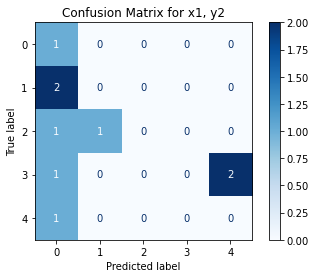

Predicted values using x2 and y2: [0 0 0 3 0 1 1 0 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.2666666666666667 and AUC score of 0.6625 



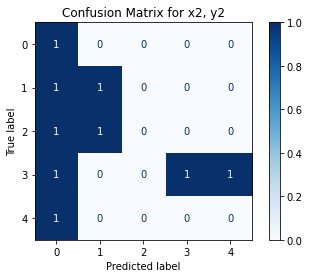

Predicted values using x3 and y2: [4 1 1 3 4 4 0 0 4]
Expected values: [0 1 2 3 4 1 2 3 3]
Resulting in an accuracy score of: 0.3333333333333333 and f1 score of: 0.27999999999999997 and AUC score of 0.7833333333333334 



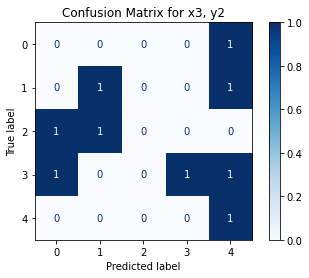

In [24]:
# x1 y2
x1y2_MLP = MLPClassifier(max_iter=2000,solver='lbfgs',early_stopping=True,learning_rate='adaptive',activation='tanh',hidden_layer_sizes=1500,alpha=0.09)
x1y2_MLP.fit(X1_sim, y2_sim)

x1y2_predict = x1y2_MLP.predict(X1_exp)
x1y2_accuracy_score = accuracy_score(y2_exp,x1y2_predict)
x1y2_f1_score = f1_score(y2_exp,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_MLP.predict_proba(X1_exp)
x1y2_AUC_score = roc_auc_score(y2_exp,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_MLP,X1_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_MLP = MLPClassifier(max_iter=2000,solver='lbfgs',early_stopping=True,learning_rate='adaptive',activation='tanh',hidden_layer_sizes=1500,alpha=0.09)
x2y2_MLP.fit(X2_sim, y2_sim)

x2y2_predict = x2y2_MLP.predict(X2_exp)
x2y2_accuracy_score = accuracy_score(y2_exp,x2y2_predict)
x2y2_f1_score = f1_score(y2_exp,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_MLP.predict_proba(X2_exp)
x2y2_AUC_score = roc_auc_score(y2_exp,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_MLP,X2_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_MLP = MLPClassifier(max_iter=2000,solver='lbfgs',early_stopping=True,learning_rate='adaptive',activation='tanh',hidden_layer_sizes=1500,alpha=0.09)
x3y2_MLP.fit(X3_sim, y2_sim)

x3y2_predict = x3y2_MLP.predict(X3_exp)
x3y2_accuracy_score = accuracy_score(y2_exp,x3y2_predict)
x3y2_f1_score = f1_score(y2_exp,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_MLP.predict_proba(X3_exp)
x3y2_AUC_score = roc_auc_score(y2_exp,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2_exp)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_MLP,X3_exp,y2_exp,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

# K Means Clustering

In [25]:
# x1 y1
x1y1_KM = KMeans(n_clusters=2, random_state=0)
x1y1_KM.fit(X1_sim, y1_sim)

x1y1_predict = x1y1_KM.predict(X1_exp)
x1y1_accuracy_score = accuracy_score(y1_exp,x1y1_predict)
x1y1_f1_score = f1_score(y1_exp,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1_exp,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

# x2 y1
x2y1_MLP = KMeans(n_clusters=2, random_state=0)
x2y1_MLP.fit(X2_sim, y1_sim)

x2y1_predict = x2y1_MLP.predict(X2_exp)
x2y1_accuracy_score = accuracy_score(y1_exp,x2y1_predict)
x2y1_f1_score = f1_score(y1_exp,x2y1_predict) 
x2y1_NMI_score = adjusted_mutual_info_score(y1_exp,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

# x3 y1
x3y1_MLP = KMeans(n_clusters=2, random_state=0)
x3y1_MLP.fit(X3_sim, y1_sim)

x3y1_predict = x3y1_MLP.predict(X3_exp)
x3y1_accuracy_score = accuracy_score(y1_exp,x3y1_predict)
x3y1_f1_score = f1_score(y1_exp,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1_exp,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1_exp)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [1 1 1 0 1 1 1 1 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.6666666666666666 and f1 score of: 0.7999999999999999 and NMI score of: -0.0983331213609779 

Predicted values using x2 and y1: [1 1 1 0 1 1 1 1 0]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.6666666666666666 and f1 score of: 0.7999999999999999 and NMI score of: -0.0983331213609779 

Predicted values using x3 and y1: [1 0 0 0 1 0 1 1 1]
Expected values: [0 1 1 1 1 1 1 1 1]
Resulting in an accuracy score of: 0.4444444444444444 and f1 score of: 0.6153846153846154 and NMI score of: -0.028711315305377936 

